## Imports

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image
from copy import deepcopy


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils import *

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance 
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression


import warnings
warnings.filterwarnings('ignore')




# Part 1

## Load Data

In [32]:
# Data paths
labeled_data_path = '../data/data_labeled/'
unlabeled_data_path = '../data/data_unlabeled/'

# Image paths
img_test_unlabeled_path = '../data/data_labeled/Img_test/'
img_train_unlabeled_path = '../data/data_labeled/Img_train/'
X_img_path = '../data/data_unlabeled/Img/'

# Load csv's
X_test = pd.read_csv(labeled_data_path + 'X_test.csv')
X_train = pd.read_csv(labeled_data_path + 'X_train.csv')
y_test = pd.read_csv(labeled_data_path + 'y_test.csv', header=None)
y_train = pd.read_csv(labeled_data_path + 'y_train.csv', header=None)
X_unlabeled = pd.read_csv(unlabeled_data_path + 'X.csv')

X_test.head()

,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,profession,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,img_filename
0,85,106.92,2.25,120.85,14.90,7.41,3.26,resource extraction,Low,High,Moderate,36.27,93.20,heart_0.png
1,130,94.73,2.61,121.74,16.88,7.53,4.74,manufacturing,Very high,Very high,Moderate,25.97,105.24,heart_6.png
2,180,110.31,2.47,75.35,15.52,8.02,4.29,manufacturing,High,Moderate,Very low,37.53,100.61,heart_7.png
3,78,95.46,2.28,125.30,11.68,7.75,4.17,services,Very low,Low,Moderate,28.19,103.94,heart_10.png
4,116,106.13,2.11,89.98,14.83,7.89,4.73,resource extraction,Low,Very high,Low,30.07,82.53,heart_11.png


## Preprocess Data

In [33]:

X_train_clean = X_train.copy()
X_test_clean = X_test.copy()
X_unlabeled_clean = X_unlabeled.copy()

X_train = X_train.drop(columns=['img_filename'])
X_test = X_test.drop(columns=['img_filename'])
X_unlabeled = X_unlabeled.drop(columns=['img_filename'])

X_train = pd.get_dummies(X_train, columns=['profession'])
X_test = pd.get_dummies(X_test, columns=['profession'])
X_unlabeled = pd.get_dummies(X_unlabeled, columns=['profession'])

consumption_map = {
    'Very low': 1,
    'Low': 2,
    'Moderate': 3,
    'High': 4,
    'Very high': 5
}

for col in ['sarsaparilla', 'smurfberry liquor', 'smurfin donuts']:
    X_train[col] = X_train[col].map(consumption_map)
    X_test[col] = X_test[col].map(consumption_map)
    X_unlabeled[col] = X_unlabeled[col].map(consumption_map)
    

X_train_original = X_train.copy()
X_test_original = X_test.copy()
X_unlabeled_original = X_unlabeled.copy()


## Feature Selection

### Filter

#### Mutual Information

In [34]:

mi_scores = mutual_info_regression(X_train, y_train.values.ravel(), random_state=42)
mi_df = pd.DataFrame({'Feature': X_train.columns, 'MI': mi_scores})
mi_df = mi_df.sort_values(by='MI', ascending=False).reset_index(drop=True)


mean_mi, std_mi = mi_df['MI'].mean(), mi_df['MI'].std()

threshold_soft = mean_mi + 0.3 * std_mi
selected_by_threshold = mi_df[mi_df['MI'] > threshold_soft]['Feature'].tolist()
print(len(selected_by_threshold))
if len(selected_by_threshold) < 6:
    selected_by_threshold = mi_df[mi_df['MI'] > 0]['Feature'].tolist()

print(f"\n Seuil souple = {threshold_soft:.4f}")
print(f"{len(selected_by_threshold)} features retenues après filtrage MI :")
print(selected_by_threshold)

selected_features_mi = selected_by_threshold
X_train_mi = X_train[selected_features_mi].copy()
X_test_mi  = X_test[selected_features_mi].copy()
X_unlabeled_mi = X_unlabeled[selected_features_mi].copy()

4

 Seuil souple = 0.0610
14 features retenues après filtrage MI :
['blood pressure', 'cholesterol', 'weight', 'smurfin donuts', 'potassium', 'sarsaparilla', 'vitamin D', 'profession_administration and governance', 'age', 'hemoglobin', 'profession_services', 'profession_food production', 'profession_resource extraction', 'profession_manufacturing']


#### Maximum relevance and minimum redundancy

In [35]:
corr_matrix = X_train_mi.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col] > 0.85)]
X_train_mrmr = X_train_mi.drop(columns=high_corr, errors='ignore')
#X_val_mrmr = X_val_mi.drop(columns=high_corr, errors='ignore')
X_test_mrmr = X_test_mi.drop(columns=high_corr, errors='ignore')
X_unlabeled_mrmr = X_unlabeled_mi.drop(columns=high_corr, errors='ignore')
y_train_ravel = y_train.values.ravel()
print(f"\n{len(high_corr)} variables redondantes supprimées après mRMR simplifié :")
print(high_corr)
print(f"{X_train_mrmr.shape[1]} features restantes après mRMR.")


0 variables redondantes supprimées après mRMR simplifié :
[]
14 features restantes après mRMR.


#### RF selection

In [36]:

rf_selector = RandomForestRegressor(n_estimators=100, random_state =42, n_jobs=-1)
rf_selector.fit(X_train_mrmr, y_train_ravel)

importances = rf_selector.feature_importances_
feature_names = X_train_mrmr.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 des caractéristiques selon Random Forest Importance:")
print(feature_importances_df.head(10))


Top 10 des caractéristiques selon Random Forest Importance:
                           Feature  Importance
0                   blood pressure    0.581197
9                       hemoglobin    0.117307
4                        potassium    0.098481
2                           weight    0.044934
8                              age    0.043431
1                      cholesterol    0.039196
6                        vitamin D    0.027567
5                     sarsaparilla    0.019582
3                   smurfin donuts    0.010945
12  profession_resource extraction    0.004388


In [37]:


linreg_final = LinearRegression()
linreg_final.fit(X_train_mrmr, y_train)

y_pred_test = linreg_final.predict(X_test_mrmr)
rmse_test_linear = compute_rmse(y_pred_test, y_test)
print(f"\nRMSE sur test = {rmse_test_linear:.4f}")

y_pred_unlabeled = linreg_final.predict(X_unlabeled_mrmr)


print("\nFichier y_pred.csv généré avec succès !")


RMSE sur test = 0.0571

Fichier y_pred.csv généré avec succès !


# Part 2

In [38]:
rmse_scorer_for_rfecv = make_scorer(compute_rmse, greater_is_better=False)
rf_estimator = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("Début de la sélection de caractéristiques RFECV (Cross-Validation) en utilisant la RMSE...")
rfecv_selector = RFECV(
    estimator=rf_estimator,
    step=1,
    cv=5,                             # Utilise 5 plis de Cross-Validation
    scoring=rmse_scorer_for_rfecv,    # Utilisation de votre RMSE scorer
    n_jobs=-1,
    verbose=1
)
rfecv_selector.fit(X_train_mrmr, y_train_ravel)

N_optimal = rfecv_selector.n_features_
print(f"\nNombre optimal de caractéristiques (N) déterminé par CV : {N_optimal}")
selected_features_rfecv = X_train_mrmr.columns[rfecv_selector.support_].tolist()
print("\nCaractéristiques sélectionnées :")
print(selected_features_rfecv)

X_train_part2 = X_train_mrmr[selected_features_rfecv].copy()
X_test_part2 = X_test_mrmr[selected_features_rfecv].copy()

Début de la sélection de caractéristiques RFECV (Cross-Validation) en utilisant la RMSE...
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting e

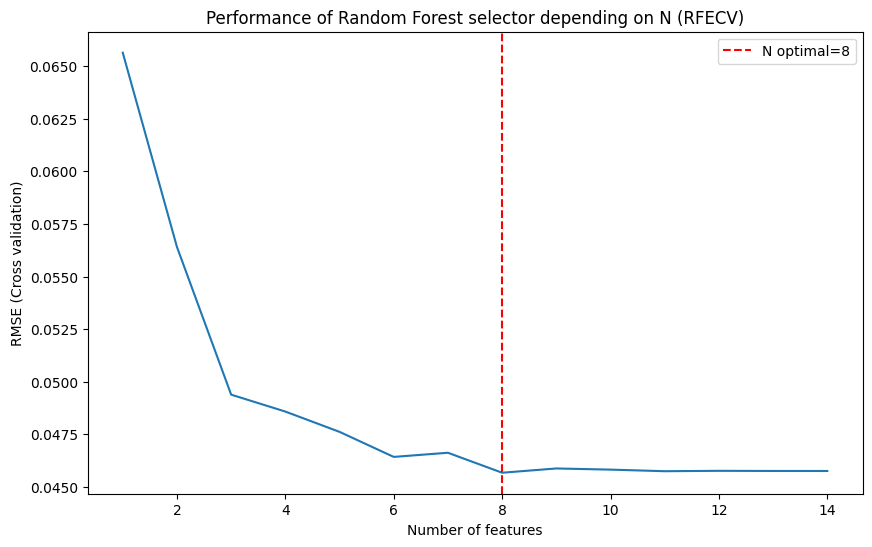

In [39]:

scores_rmse = -rfecv_selector.cv_results_['mean_test_score'] 
n_features_range = range(1, len(X_train_mrmr.columns) + 1)

plt.figure(figsize=(10, 6))
plt.plot(n_features_range, scores_rmse)
plt.xlabel("Number of features")
plt.ylabel("RMSE (Cross validation)")
plt.title("Performance of Random Forest selector depending on N (RFECV)")
plt.axvline(x=N_optimal, color='r', linestyle='--', label=f'N optimal={N_optimal}')
plt.legend()
#plt.savefig("C:/Users/User/Desktop/GBIOM2/LELEC2870_Machine_learning/LELEC2870-Project/plots/performance_rf_selection.pdf")
plt.show()


--- Optimisation du MLP (Simple) ---

--- Optimisation du Multi-Layer Perceptron (MLP) ---
Début du tuning MLP...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 60), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.1s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 60), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.1s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 60), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.1s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 60), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.1s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(200, 120), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.3s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(200, 120), mlp__learning_rate_init=0.016, mlp__solver=adam; total time=   0.3s
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(200, 120), mlp__lea

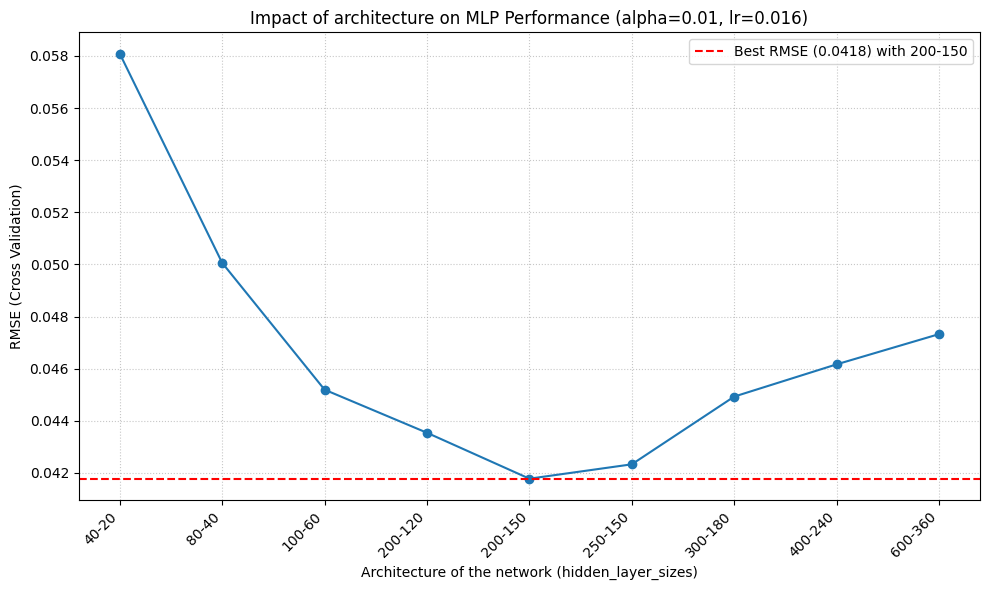

In [40]:
print("\n--- Optimisation du MLP (Simple) ---")

mlp_base_estimator = MLPRegressor(max_iter=500, random_state=42)

pipe_mlp_fine_tune = Pipeline([
    ('scaler', StandardScaler()), 
    ('mlp', mlp_base_estimator) 
])
param_grid_mlp_final = {
    'mlp__hidden_layer_sizes': [(40,20), (80, 40), (100, 60), (200, 120),(200,150), (250, 150),(300, 180),(400, 240), (600, 360)], 
    'mlp__activation': ['relu'],
    'mlp__alpha': [0.01],
    'mlp__learning_rate_init': [0.016], 
    
    'mlp__solver': ['adam']
}

mlp_grid_final = GridSearchCV(
    estimator=pipe_mlp_fine_tune,
    param_grid=param_grid_mlp_final,
    scoring=rmse_scorer_for_rfecv, 
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("\n--- Optimisation du Multi-Layer Perceptron (MLP) ---")
print("Début du tuning MLP...")

mlp_grid_final.fit(X_train_part2, y_train_ravel) 

best_rmse_val_mlp_final = -mlp_grid_final.best_score_ 

print(f"\nMeilleur RMSE (Validation Croisée MLP) : {best_rmse_val_mlp_final:.4f}")
print(f"Meilleurs hyperparamètres MLP : {mlp_grid_final.best_params_}")

best_mlp_model_final = mlp_grid_final.best_estimator_

results = pd.DataFrame(mlp_grid_final.cv_results_)

def format_architecture(hls_tuple):
    if isinstance(hls_tuple, tuple):
        return '-'.join(map(str, hls_tuple))
    return str(hls_tuple)

results['Architecture_str'] = results['param_mlp__hidden_layer_sizes'].apply(format_architecture)

best_alpha = mlp_grid_final.best_params_['mlp__alpha']
best_lr = mlp_grid_final.best_params_['mlp__learning_rate_init']

filtered_results = results[
    (results['param_mlp__alpha'] == best_alpha) & 
    (results['param_mlp__learning_rate_init'] == best_lr) &
    (results['param_mlp__activation'] == 'relu')
].copy()

results['RMSE_CV'] = -results['mean_test_score']
plt.figure(figsize=(10, 6))

plt.plot(
    results['Architecture_str'], 
    results['RMSE_CV'], 
    marker='o', 
    linestyle='-', 
    color='#1f77b4'
)

min_rmse = results['RMSE_CV'].min()
best_arch = results.loc[results['RMSE_CV'].idxmin(), 'Architecture_str']
plt.axhline(y=min_rmse, color='r', linestyle='--', 
            label=f'Best RMSE ({min_rmse:.4f}) with {best_arch}')

plt.xlabel("Architecture of the network (hidden_layer_sizes)")
plt.ylabel("RMSE (Cross Validation)")
plt.title(f"Impact of architecture on MLP Performance (alpha={best_alpha}, lr={best_lr})")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Le score de généralisation final est du pour le mlp est : 0.0428


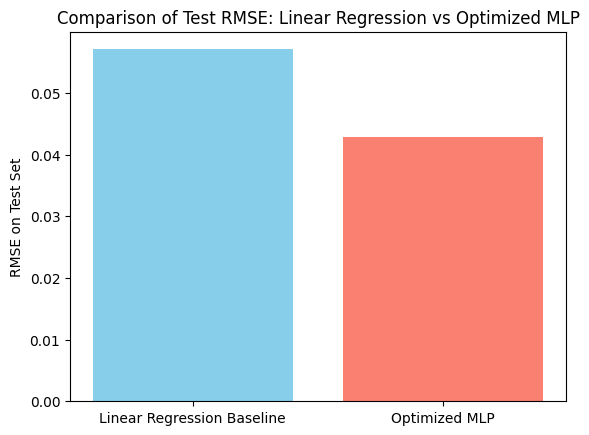

In [41]:

# Prédictions sur l'ensemble de Test
y_test_ravel = y_test.values.ravel() if hasattr(y_test, 'values') else y_test.ravel()
y_pred_test_mlp = best_mlp_model_final.predict(X_test_part2)

rmse_test_mlp = compute_rmse(y_pred_test_mlp, y_test_ravel)

linearBaseline = rmse_test_linear

print(f"Le score de généralisation final est du pour le mlp est : {rmse_test_mlp:.4f}")
labels = ['Linear Regression Baseline', 'Optimized MLP']
rmse_values = [linearBaseline, rmse_test_mlp]
plt.bar(labels, rmse_values, color=['skyblue', 'salmon'])
plt.ylabel('RMSE on Test Set')
plt.title('Comparison of Test RMSE: Linear Regression vs Optimized MLP')
plt.show()  

# Part3

Index(['age', 'blood pressure', 'calcium', 'cholesterol', 'hemoglobin',
       'height', 'potassium', 'profession', 'sarsaparilla',
       'smurfberry liquor', 'smurfin donuts', 'vitamin D', 'weight',
       'img_filename'],
      dtype='object')
Train: (1000, 8), Test: (500, 8)
t-SNE on pixel values


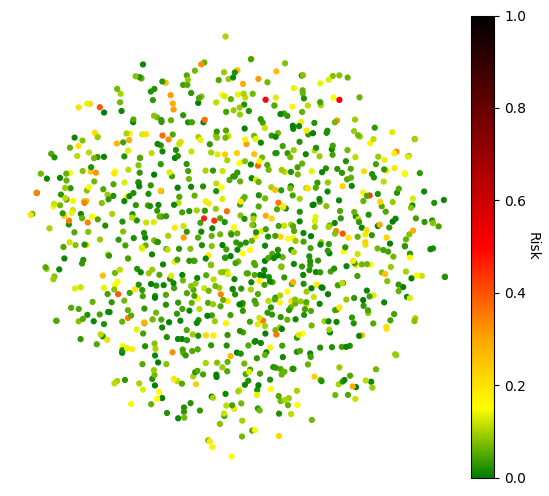

In [42]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)


y_test = pd.read_csv(labeled_data_path + 'y_test.csv', header=None)
y_train = pd.read_csv(labeled_data_path + 'y_train.csv', header=None)

X_train = X_train_clean
X_test = X_test_clean
X_unlabeled = X_unlabeled_clean

print(X_train.columns)
cols = [
    'blood pressure', 'cholesterol', 'weight', 'potassium',
    'sarsaparilla', 'vitamin D', 'age', 'hemoglobin'
]
X_train = pd.get_dummies(X_train, columns=['profession'])
X_test = pd.get_dummies(X_test, columns=['profession'])
X_unlabeled = pd.get_dummies(X_unlabeled, columns=['profession'])
# Ordinal encoding of consumption features
consumption_map = {
    'Very low': 1,
    'Low': 2,
    'Moderate': 3,
    'High': 4,
    'Very high': 5
}

for col in ['sarsaparilla', 'smurfberry liquor', 'smurfin donuts']:
    X_train[col] = X_train[col].map(consumption_map)
    X_test[col] = X_test[col].map(consumption_map)
    X_unlabeled[col] = X_unlabeled[col].map(consumption_map)


# Separate image filenames and tabular features
img_train = X_train["img_filename"].astype(str).values
img_test = X_test["img_filename"].astype(str).values

X_tab_train = X_train.drop(columns=["img_filename"])
X_tab_test = X_test.drop(columns=["img_filename"])

X_tab_train = X_tab_train[cols]
X_tab_test  = X_tab_test[cols]

y_train = y_train.values.ravel() if hasattr(y_train, 'values') else np.asarray(y_train).ravel()
y_test  = y_test.values.ravel()  if hasattr(y_test,  'values') else np.asarray(y_test).ravel()

print(f"Train: {X_tab_train.shape}, Test: {X_tab_test.shape}")

dataset_viz = CustomImageDataset(
    images=img_train, 
    images_directory="../data/data_labeled/Img_train", 
    target=y_train
)
print("t-SNE on pixel values")
visualize_dataset_tSNE(dataset_viz, extract_features=False, perplexity=30, random_state=42, zoom=2.0)




In [43]:
import os
import numpy as np

IMAGE_DIR_TRAIN = "../data/data_labeled/Img_train"
IMAGE_DIR_TEST  = "../data/data_labeled/Img_test"

from sklearn.model_selection import KFold
from sklearn.base import clone
import numpy as np

X_tab_train_np = X_tab_train.values if hasattr(X_tab_train, "values") else np.asarray(X_tab_train)

n_features_list = [2]
kfold = KFold(n_splits=5, shuffle=True)

cv_summary = []

for nf in n_features_list:
    print(f"\n=== CV for n_features = {nf} ===")
    fold_rmses = []

    for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_tab_train_np)):
        X_tab_tr  = X_tab_train_np[train_idx]
        X_tab_val = X_tab_train_np[val_idx]
        y_tr      = y_train[train_idx]
        y_val     = y_train[val_idx]
        img_tr    = img_train[train_idx]
        img_val   = img_train[val_idx]

        # Train CNN on fold's train images
        cnn_cv = MyCNN(n_features=nf, n_epochs=60, batch_size=50, learning_rate=5e-4)
        _ = cnn_cv.fit(images=img_tr, y=y_tr, data_dir=IMAGE_DIR_TRAIN)

        # Extract features for train/val from TRAIN folder
        Z_tr  = cnn_cv.extract_features(images=img_tr,  data_dir=IMAGE_DIR_TRAIN)
        Z_val = cnn_cv.extract_features(images=img_val, data_dir=IMAGE_DIR_TRAIN)

        # Combine tabular + image features
        X_comb_tr  = np.hstack([X_tab_tr,  Z_tr])
        X_comb_val = np.hstack([X_tab_val, Z_val])

        # Fit cloned MLP and evaluate on val
        mlp_cv = clone(best_mlp_model_final)
        mlp_cv.fit(X_comb_tr, y_tr)
        y_pred_val = mlp_cv.predict(X_comb_val)

        rmse_val = compute_rmse(y_val, y_pred_val)
        fold_rmses.append(rmse_val)
        print(f"  Fold {fold_idx+1}: RMSE = {rmse_val:.4f}")

    rmse_mean = float(np.mean(fold_rmses))
    rmse_std  = float(np.std(fold_rmses))
    cv_summary.append({"n_features": nf, "rmse_mean": rmse_mean, "rmse_std": rmse_std})
    print(f"n_features={nf}: mean RMSE = {rmse_mean:.4f} ± {rmse_std:.4f}")


=== CV for n_features = 2 ===


Epoch  5 | Train RMSE 0.0983 | Val RMSE 0.0892
Epoch 10 | Train RMSE 0.0859 | Val RMSE 0.0878
Epoch 15 | Train RMSE 0.0842 | Val RMSE 0.0865
Epoch 20 | Train RMSE 0.0804 | Val RMSE 0.0843
Epoch 25 | Train RMSE 0.0779 | Val RMSE 0.0804
Epoch 30 | Train RMSE 0.0754 | Val RMSE 0.0783
Epoch 35 | Train RMSE 0.0735 | Val RMSE 0.0765
Epoch 40 | Train RMSE 0.0728 | Val RMSE 0.0759
Epoch 45 | Train RMSE 0.0707 | Val RMSE 0.0749
Epoch 50 | Train RMSE 0.0699 | Val RMSE 0.0738
Epoch 55 | Train RMSE 0.0685 | Val RMSE 0.0733


KeyboardInterrupt: 

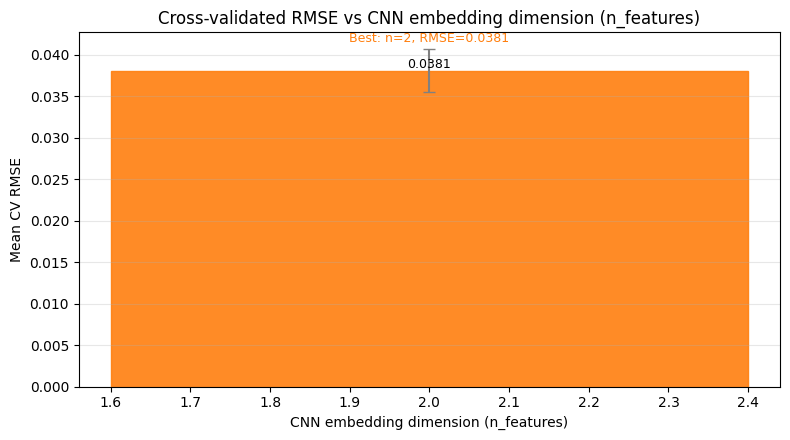

In [ ]:
cv_summary_sorted = sorted(cv_summary, key=lambda d: d["n_features"])
nfs   = [d["n_features"] for d in cv_summary_sorted]
means = [d["rmse_mean"]   for d in cv_summary_sorted]
stds  = [d["rmse_std"]    for d in cv_summary_sorted]

plt.figure(figsize=(8, 4.5))
bars = plt.bar(nfs, means, yerr=stds, capsize=4, color='tab:blue', alpha=0.8, ecolor='gray')

best_idx = int(min(range(len(means)), key=lambda i: means[i]))
bars[best_idx].set_color('tab:orange')
bars[best_idx].set_alpha(0.9)
plt.text(nfs[best_idx], means[best_idx] + stds[best_idx] + 0.0005,
         f"Best: n={nfs[best_idx]}, RMSE={means[best_idx]:.4f}",
         ha='center', va='bottom', fontsize=9, color='tab:orange')

for x, y in zip(nfs, means):
    plt.text(x, y, f"{y:.4f}", ha='center', va='bottom', fontsize=9)

plt.title("Cross-validated RMSE vs CNN embedding dimension (n_features)")
plt.xlabel("CNN embedding dimension (n_features)")
plt.ylabel("Mean CV RMSE")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Select best n_features
best_entry = sorted(cv_summary, key=lambda d: d["rmse_mean"])[0]
best_nf = best_entry["n_features"]
print(f"\nBest N_FEATURES by CV: {best_nf} (mean RMSE = {best_entry['rmse_mean']:.4f} ± {best_entry['rmse_std']:.4f})")



Best N_FEATURES by CV: 2 (mean RMSE = 0.0381 ± 0.0026)


Epoch  5 | Train RMSE 0.0882 | Val RMSE 0.0856
Epoch 10 | Train RMSE 0.0837 | Val RMSE 0.0833
Epoch 15 | Train RMSE 0.0815 | Val RMSE 0.0810
Epoch 20 | Train RMSE 0.0778 | Val RMSE 0.0803
Epoch 25 | Train RMSE 0.0748 | Val RMSE 0.0772
Epoch 30 | Train RMSE 0.0715 | Val RMSE 0.0737
Epoch 35 | Train RMSE 0.0681 | Val RMSE 0.0752
Epoch 40 | Train RMSE 0.0661 | Val RMSE 0.0701
Epoch 45 | Train RMSE 0.0634 | Val RMSE 0.0691
Epoch 50 | Train RMSE 0.0626 | Val RMSE 0.0686
Epoch 55 | Train RMSE 0.0610 | Val RMSE 0.0689
Epoch 60 | Train RMSE 0.0601 | Val RMSE 0.0717


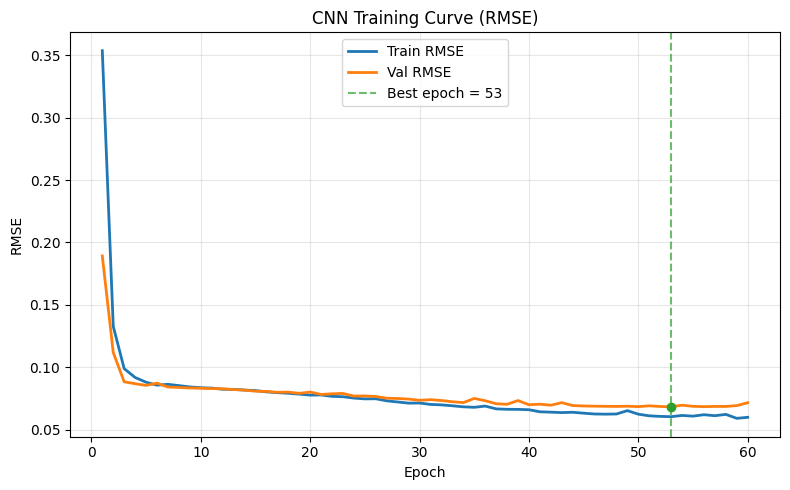

In [ ]:

# Retrain on full TRAIN with best_nf and evaluate on TEST
cnn_best = MyCNN(n_features=best_nf, n_epochs=60, batch_size=50, learning_rate=5e-4)
history = cnn_best.fit(images=img_train, y=y_train, data_dir=IMAGE_DIR_TRAIN)
Z_train_best = cnn_best.extract_features(images=img_train, data_dir=IMAGE_DIR_TRAIN)
Z_test_best  = cnn_best.extract_features(images=img_test,  data_dir=IMAGE_DIR_TEST)

X_comb_train_best = np.hstack([X_tab_train_np, Z_train_best])
X_comb_test_best  = np.hstack([X_tab_test.values if hasattr(X_tab_test, "values") else np.asarray(X_tab_test), Z_test_best])

plot_cnn_training_curves(
    history,
    best_epoch=cnn_best.best_epoch,
    best_val_rmse=cnn_best.best_val_rmse,
    title="CNN Training Curve (RMSE)"
)


In [ ]:
# Tabular-only baseline

rmse_tab_test = rmse_test_mlp 
print("Tabular-only MLP:")
print(f"  Test RMSE: {rmse_test_mlp:.4f}")

Tabular-only MLP:
  Test RMSE: 0.0428


t-SNE on extracted CNN features


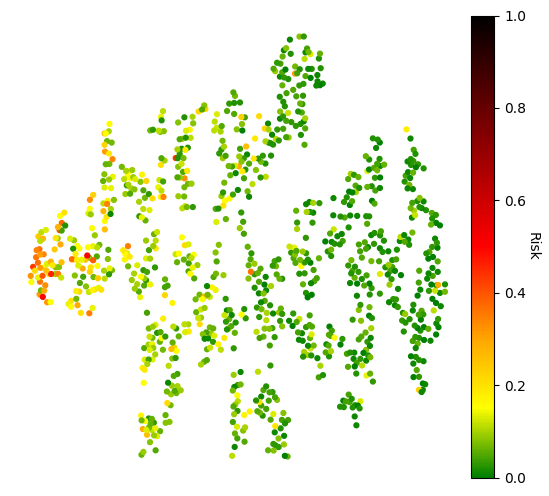

In [ ]:
print("t-SNE on extracted CNN features")
visualize_dataset_tSNE(dataset_viz, extract_features=True, feature_extractor=cnn_best, perplexity=30, random_state=42, zoom=2.0)

Final test RMSE with N_FEATURES=2: 0.0354

Tabular + Image MLP:
  Test RMSE: 0.0354


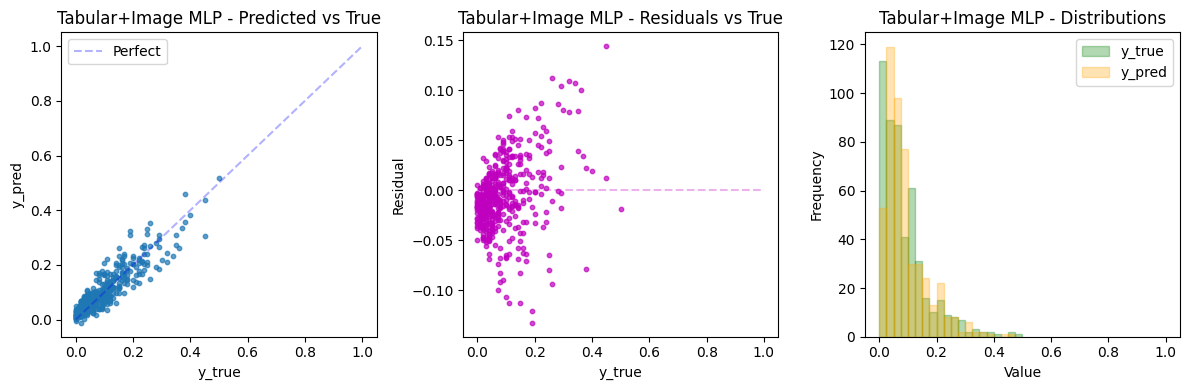

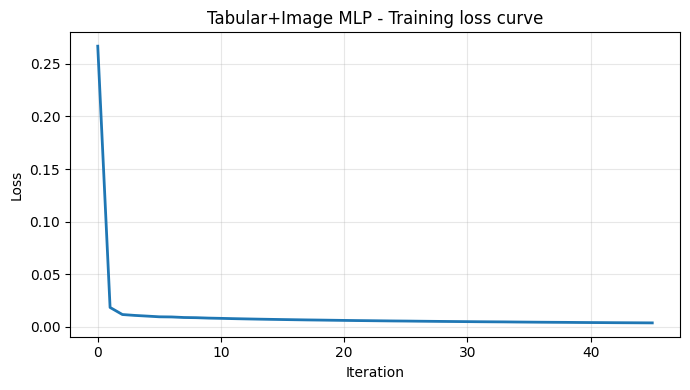

In [ ]:
X_comb_train_best = np.hstack([X_tab_train_np, Z_train_best])
X_comb_test_best  = np.hstack([X_tab_test.values if hasattr(X_tab_test, "values") else np.asarray(X_tab_test), Z_test_best])

best_mlp_final_cv = clone(best_mlp_model_final)
best_mlp_final_cv.fit(X_comb_train_best, y_train)
y_pred_test_best = best_mlp_final_cv.predict(X_comb_test_best)
rmse_test_best = compute_rmse(y_test, y_pred_test_best)
print(f"Final test RMSE with N_FEATURES={best_nf}: {rmse_test_best:.4f}")

print("\nTabular + Image MLP:")
print(f"  Test RMSE: {rmse_test_best:.4f}")

visualize_regression_results(y_test, y_pred_test_best, title_prefix="Tabular+Image MLP - ")

plot_mlp_loss_curve(best_mlp_final_cv, title="Tabular+Image MLP - Training loss curve")

In [ ]:
print("\n=======================================================")
print("Final Test Comparison (lower RMSE is better)")
print("-------------------------------------------------------")
print(f"Tabular-only MLP     : {rmse_tab_test:.4f}")
print(f"Tabular+Image MLP    : {rmse_test_best:.4f}")
print("=======================================================")

improvement = rmse_tab_test - rmse_test_best
print(f"Absolute improvement (RMSE): {improvement:+.4f}")


Final Test Comparison (lower RMSE is better)
-------------------------------------------------------
Tabular-only MLP     : 0.0428
Tabular+Image MLP    : 0.0354
Absolute improvement (RMSE): +0.0074


Cross-validating kernel features on TRAIN (fused with Tabular+CNN baseline)...

=== Kernel: blur_soft ===
  Fold 1: RMSE = 0.0345
  Fold 2: RMSE = 0.0731
  Fold 3: RMSE = 0.0702
  Fold 4: RMSE = 0.0345
  Fold 5: RMSE = 0.0363
Kernel blur_soft: mean CV RMSE = 0.0497 ± 0.0179

=== Kernel: sharpen ===
  Fold 1: RMSE = 0.0365
  Fold 2: RMSE = 0.0395
  Fold 3: RMSE = 0.0422
  Fold 4: RMSE = 0.0353
  Fold 5: RMSE = 0.0359
Kernel sharpen: mean CV RMSE = 0.0379 ± 0.0026

=== Kernel: laplacian_4 ===
  Fold 1: RMSE = 0.0320
  Fold 2: RMSE = 0.0382
  Fold 3: RMSE = 0.0386
  Fold 4: RMSE = 0.0357
  Fold 5: RMSE = 0.0446
Kernel laplacian_4: mean CV RMSE = 0.0378 ± 0.0041

=== Kernel: laplacian_8 ===
  Fold 1: RMSE = 0.0370
  Fold 2: RMSE = 0.0418
  Fold 3: RMSE = 0.0441
  Fold 4: RMSE = 0.0386
  Fold 5: RMSE = 0.0419
Kernel laplacian_8: mean CV RMSE = 0.0407 ± 0.0025

=== Kernel: sobel_x ===
  Fold 1: RMSE = 0.0363
  Fold 2: RMSE = 0.0410
  Fold 3: RMSE = 0.0456
  Fold 4: RMSE = 0.0383
  Fold 5: RM

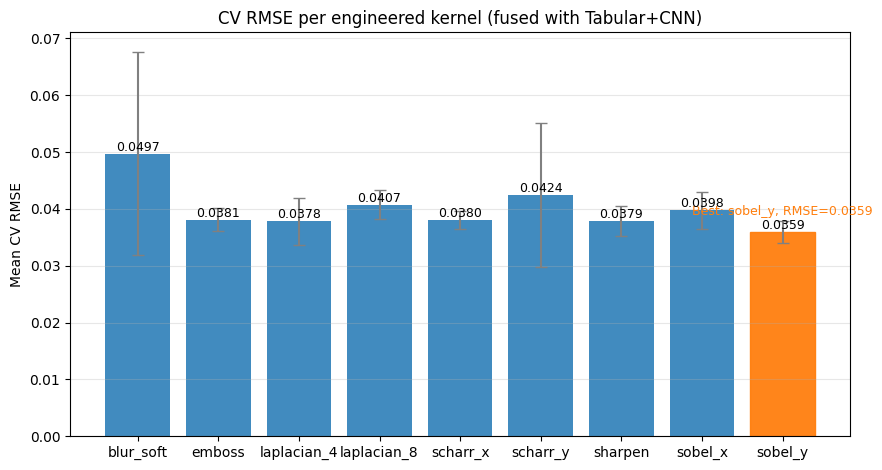

>>> Best kernel by CV: sobel_y (mean RMSE = 0.0359 ± 0.0019)

Final TEST comparison (lower RMSE is better)
Baseline Tabular+Image      : 0.0354
Tabular+Image+Best Kernel   : 0.0425
Δ vs baseline               : -0.0071


In [ ]:

import numpy as np
from sklearn.model_selection import KFold
from sklearn.base import clone
import matplotlib.pyplot as plt


kfold = KFold(n_splits=5, shuffle=True, random_state=42)
kernel_cv_summary = []

print("Cross-validating kernel features on TRAIN (fused with Tabular+CNN baseline)...\n")

for kname, kmat in KERNEL_BANK.items():
    fold_rmses = []
    print(f"=== Kernel: {kname} ===")
    for fold_idx, (tr_idx, val_idx) in enumerate(kfold.split(X_comb_train_best)):
        X_fused_tr  = X_comb_train_best[tr_idx]
        X_fused_val = X_comb_train_best[val_idx]
        y_tr        = y_train[tr_idx]
        y_val       = y_train[val_idx]

        img_tr_fold  = img_train[tr_idx]
        img_val_fold = img_train[val_idx]

        feats_tr, _  = extract_engineered_kernel_features(
            img_tr_fold, IMAGE_DIR_TRAIN, {kname: kmat},
            include_unsharp=False, include_dog=False
        )
        feats_val, _ = extract_engineered_kernel_features(
            img_val_fold, IMAGE_DIR_TRAIN, {kname: kmat},
            include_unsharp=False, include_dog=False
        )

        X_tr_aug  = np.hstack([X_fused_tr,  feats_tr])
        X_val_aug = np.hstack([X_fused_val, feats_val])

        model_cv = clone(best_mlp_model_final)
        model_cv.fit(X_tr_aug, y_tr)
        y_pred_val = model_cv.predict(X_val_aug)
        rmse_val = compute_rmse(y_val, y_pred_val)
        fold_rmses.append(rmse_val)
        print(f"  Fold {fold_idx+1}: RMSE = {rmse_val:.4f}")

    rmse_mean = float(np.mean(fold_rmses))
    rmse_std  = float(np.std(fold_rmses))
    kernel_cv_summary.append({"kernel": kname, "rmse_mean": rmse_mean, "rmse_std": rmse_std, "rmses": fold_rmses})
    print(f"Kernel {kname}: mean CV RMSE = {rmse_mean:.4f} ± {rmse_std:.4f}\n")

kernel_cv_sorted = sorted(kernel_cv_summary, key=lambda d: d["kernel"])
names = [d["kernel"] for d in kernel_cv_sorted]
means = [d["rmse_mean"] for d in kernel_cv_sorted]
stds  = [d["rmse_std"]  for d in kernel_cv_sorted]

plt.figure(figsize=(9, 4.8))
bars = plt.bar(names, means, yerr=stds, capsize=4, color='tab:blue', alpha=0.85, ecolor='gray')
best_idx = int(min(range(len(means)), key=lambda i: means[i]))
bars[best_idx].set_color('tab:orange'); bars[best_idx].set_alpha(0.95)
plt.text(best_idx, means[best_idx] + stds[best_idx] + 0.0005,
         f"Best: {names[best_idx]}, RMSE={means[best_idx]:.4f}",
         ha='center', va='bottom', fontsize=9, color='tab:orange')
for i, m in enumerate(means):
    plt.text(i, m, f"{m:.4f}", ha='center', va='bottom', fontsize=9)
plt.title("CV RMSE per engineered kernel (fused with Tabular+CNN)")
plt.ylabel("Mean CV RMSE"); plt.grid(axis='y', alpha=0.3); plt.tight_layout(); plt.show()

best_entry = sorted(kernel_cv_summary, key=lambda d: d["rmse_mean"])[0]
BEST_KERNEL_NAME = best_entry["kernel"]
BEST_KERNEL_MATRIX = KERNEL_BANK[BEST_KERNEL_NAME]
print(f">>> Best kernel by CV: {BEST_KERNEL_NAME} (mean RMSE = {best_entry['rmse_mean']:.4f} ± {best_entry['rmse_std']:.4f})")

best_train_feats, _ = extract_engineered_kernel_features(
    img_train, IMAGE_DIR_TRAIN, {BEST_KERNEL_NAME: BEST_KERNEL_MATRIX},
    include_unsharp=False, include_dog=False
)
best_test_feats, _ = extract_engineered_kernel_features(
    img_test, IMAGE_DIR_TEST, {BEST_KERNEL_NAME: BEST_KERNEL_MATRIX},
    include_unsharp=False, include_dog=False
)

X_aug_train = np.hstack([X_comb_train_best, best_train_feats])
X_aug_test  = np.hstack([X_comb_test_best,  best_test_feats])

augmented_mlp = clone(best_mlp_model_final)
augmented_mlp.set_params(mlp__max_iter=2000)
augmented_mlp.fit(X_aug_train, y_train)
y_pred_aug = augmented_mlp.predict(X_aug_test)
rmse_aug_test = compute_rmse(y_test, y_pred_aug)

print("\nFinal TEST comparison (lower RMSE is better)")
print(f"Baseline Tabular+Image      : {rmse_test_best:.4f}")
print(f"Tabular+Image+Best Kernel   : {rmse_aug_test:.4f}")
print(f"Δ vs baseline               : {rmse_test_best - rmse_aug_test:+.4f}")

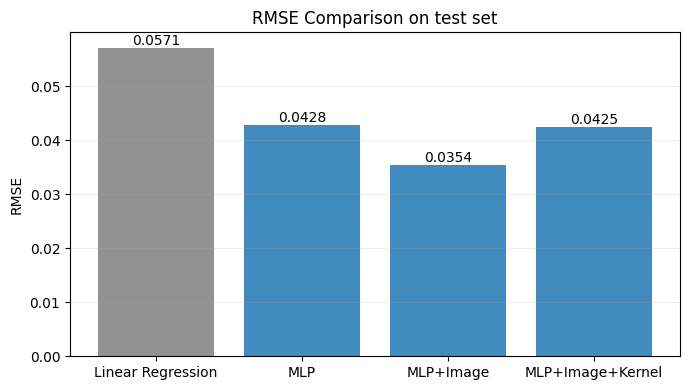

Absolute improvement MLP + Image + Kernel vs MLP: +0.0003
Absolute improvement MLP + Image + Kernel vs MLP + Image: -0.0071


In [ ]:
plot_rmse_comparison(
    {   
        "Linear Regression": rmse_test_linear,
        "MLP": rmse_tab_test,
        "MLP+Image": rmse_test_best,
        "MLP+Image+Kernel": rmse_aug_test
    },
    title="RMSE Comparison on test set"
)

print("Absolute improvement MLP + Image + Kernel vs MLP:",
      f"{rmse_tab_test - rmse_aug_test:+.4f}")
print("Absolute improvement MLP + Image + Kernel vs MLP + Image:",
      f"{rmse_test_best - rmse_aug_test:+.4f}")

In [ ]:

import os
import numpy as np
import pandas as pd

cols = [
    'blood pressure', 'cholesterol', 'weight', 'potassium',
    'sarsaparilla', 'vitamin D', 'age', 'hemoglobin'
]

X_unlabeled_aligned = X_unlabeled.copy()
missing_cols = [c for c in cols if c not in X_unlabeled_aligned.columns]
if missing_cols:
    raise ValueError(f"Unlabeled dataframe is missing required columns: {missing_cols}")
X_tab_unlabeled = X_unlabeled_aligned[cols].values

img_unlabeled = X_unlabeled_aligned['img_filename'].astype(str).values
IMAGE_DIR_UNLABELED = "../data/data_unlabeled/Img"

def exists_mask(filenames, directory):
    return np.array([os.path.exists(os.path.join(directory, f)) for f in filenames], dtype=bool)

mask_unl = exists_mask(img_unlabeled, IMAGE_DIR_UNLABELED)
if not mask_unl.all():
    missing = np.sum(~mask_unl)
    print(f"[WARN] {missing} unlabeled images not found in {IMAGE_DIR_UNLABELED}. Dropping those rows.")
    img_unlabeled   = img_unlabeled[mask_unl]
    X_tab_unlabeled = X_tab_unlabeled[mask_unl]

print("Unlabeled inputs:", X_tab_unlabeled.shape, "images:", len(img_unlabeled))

Z_unlabeled = cnn_best.extract_features(images=img_unlabeled, data_dir=IMAGE_DIR_UNLABELED)
print("Z_unlabeled shape:", Z_unlabeled.shape)

X_comb_unlabeled = np.hstack([X_tab_unlabeled, Z_unlabeled])
print("X_comb_unlabeled:", X_comb_unlabeled.shape)

Z_train_best = cnn_best.extract_features(images=img_train, data_dir=IMAGE_DIR_TRAIN)
X_comb_train_best = np.hstack([X_tab_train.values if hasattr(X_tab_train, "values") else np.asarray(X_tab_train),
                               Z_train_best])

from sklearn.base import clone
mlp_tabimg = clone(best_mlp_model_final)
mlp_tabimg.fit(X_comb_train_best, y_train)

y_pred_unlabeled = mlp_tabimg.predict(X_comb_unlabeled)

out_df = pd.DataFrame({"y_pred": y_pred_unlabeled})
out_path = "y_pred.csv"  # exact filename requested
out_df.to_csv(out_path, index=False, header=False)
print(f"Saved predictions to: {out_path}")

Unlabeled inputs: (500, 8) images: 500
Z_unlabeled shape: (500, 2)
X_comb_unlabeled: (500, 10)
Saved predictions to: y_pred.csv


# Part 4

## Comparing the most at risk with the least at risk

Top risk samples (highest):


,img_filename,blood pressure,cholesterol,weight,potassium,sarsaparilla,vitamin D,age,hemoglobin,risk
0,heart_584.png,131.15,147.62,141.18,4.62,1,22.94,143,8.54,0.50
1,heart_1369.png,136.57,142.20,126.55,5.11,2,30.20,143,10.34,0.45
2,heart_317.png,149.53,160.84,116.51,3.29,3,28.44,96,15.46,0.45
3,heart_1196.png,147.48,154.17,118.99,4.19,1,27.07,149,19.73,0.40
4,heart_1162.png,135.05,160.94,125.71,4.52,2,29.29,94,10.49,0.38
5,heart_1175.png,138.60,156.06,110.20,3.19,4,34.41,124,11.67,0.38
6,heart_813.png,138.18,153.09,124.03,3.76,2,29.76,110,17.26,0.37
7,heart_96.png,136.15,148.38,108.25,3.47,2,28.08,179,12.91,0.36
8,heart_1089.png,127.11,141.97,129.25,3.75,2,22.00,120,17.07,0.35
9,heart_548.png,134.97,98.63,94.72,3.59,1,29.29,170,16.39,0.35


Low risk samples (lowest):


,img_filename,blood pressure,cholesterol,weight,potassium,sarsaparilla,vitamin D,age,hemoglobin,risk
0,heart_1486.png,112.52,140.42,108.05,4.02,5,33.73,97,13.49,0.0
1,heart_134.png,96.70,42.13,78.34,3.81,5,25.30,145,15.72,0.0
2,heart_80.png,103.98,83.16,92.17,3.90,2,28.00,124,13.96,0.0
3,heart_1395.png,103.92,74.65,97.67,3.76,5,37.14,96,15.59,0.0
4,heart_1398.png,95.31,113.74,114.02,4.37,5,30.67,74,12.87,0.0
5,heart_174.png,114.29,103.91,76.14,4.20,5,27.96,102,16.58,0.0
6,heart_747.png,101.64,83.63,114.26,3.84,3,37.30,97,13.30,0.0
7,heart_744.png,98.72,102.54,106.55,4.55,5,27.82,157,16.60,0.0
8,heart_1320.png,104.39,109.87,90.89,4.42,2,30.62,104,15.12,0.0
9,heart_1306.png,110.00,112.99,97.53,4.11,4,33.53,100,15.38,0.0


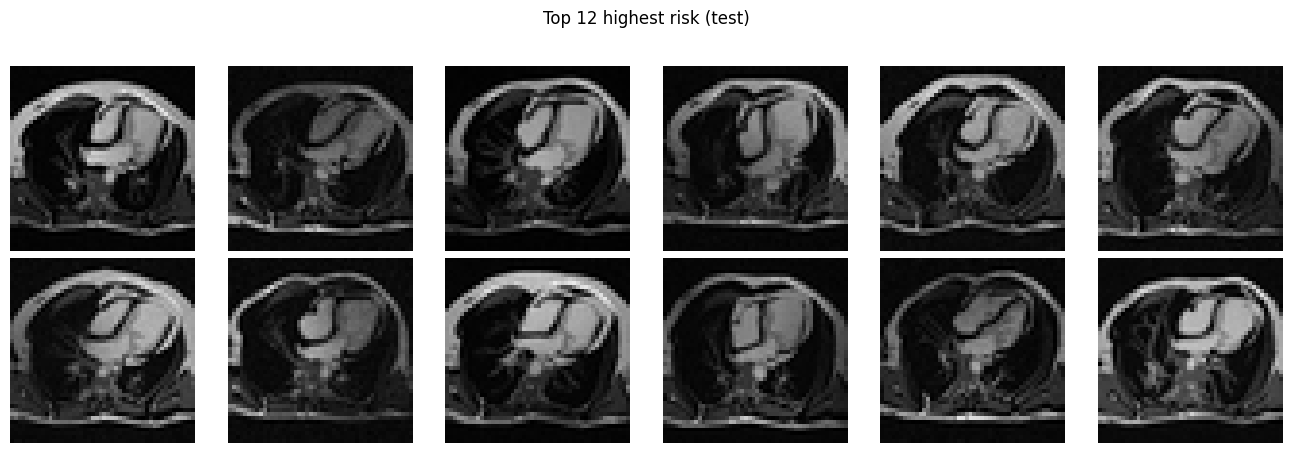

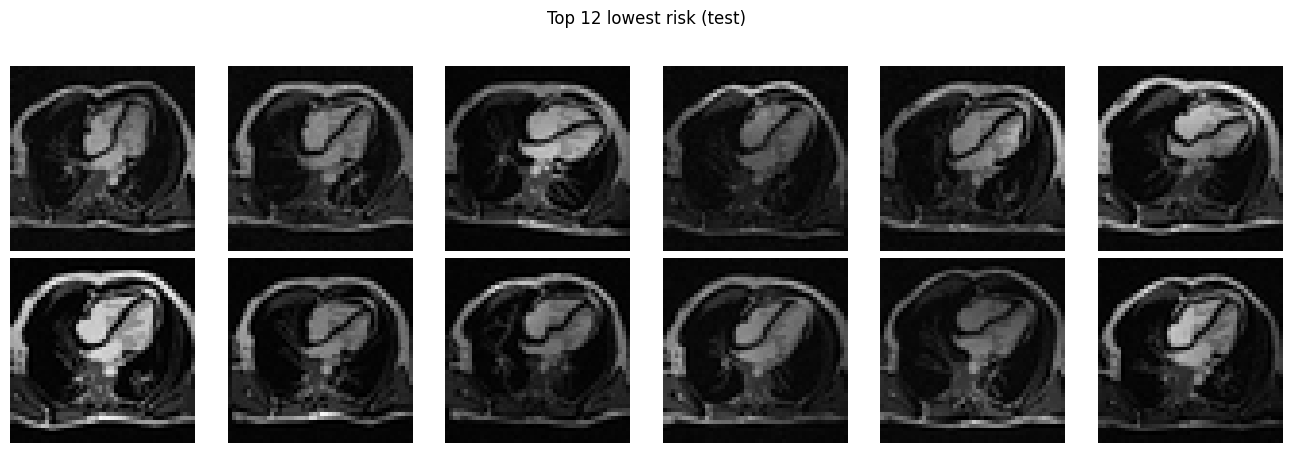

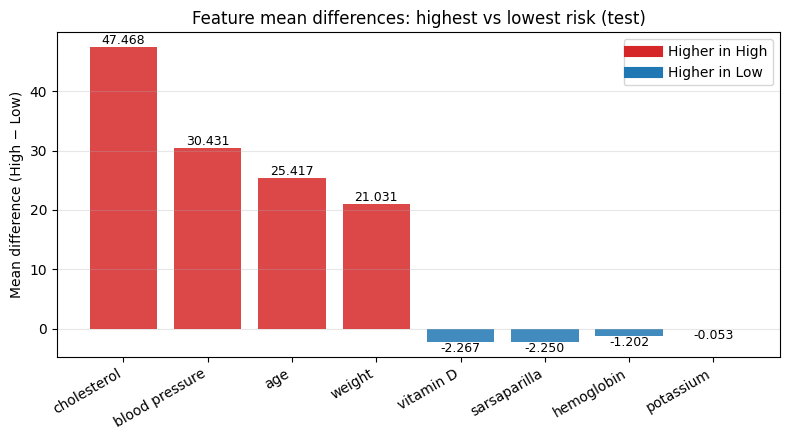

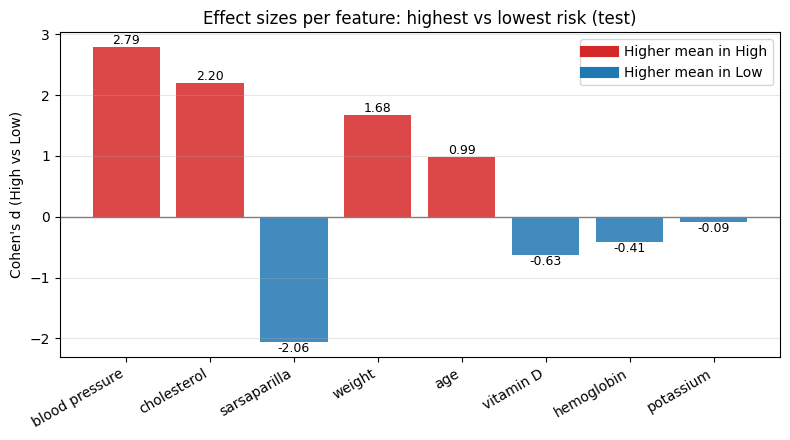

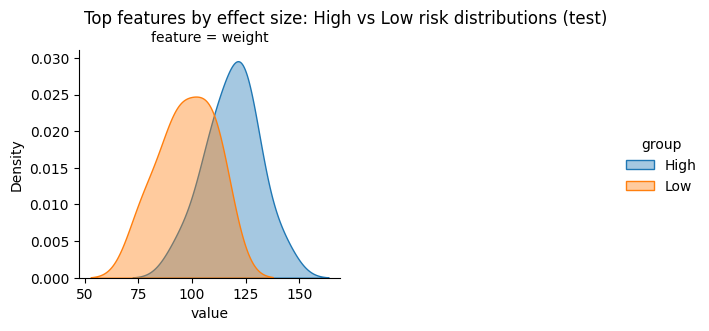

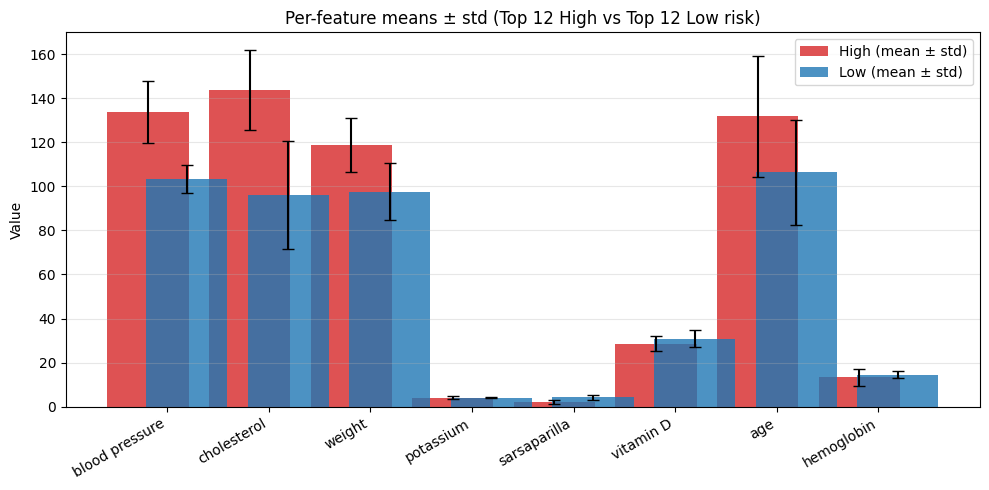

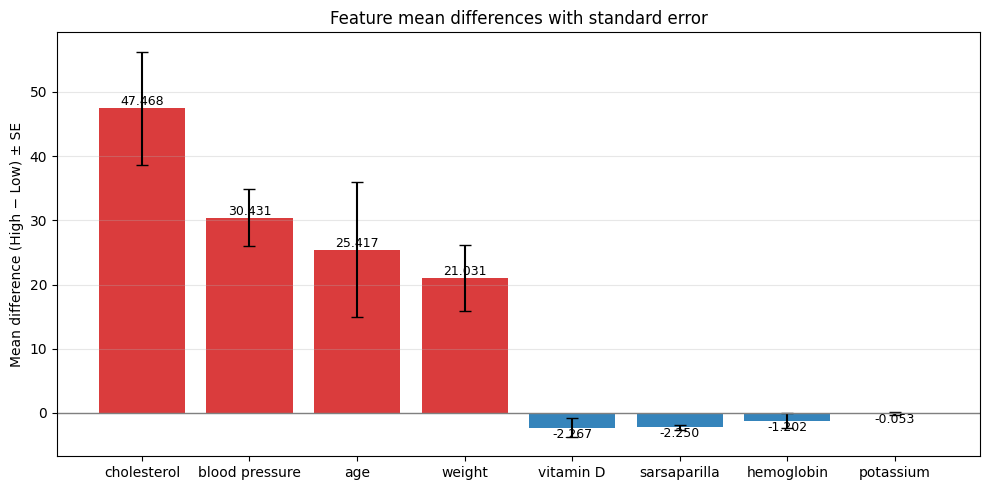

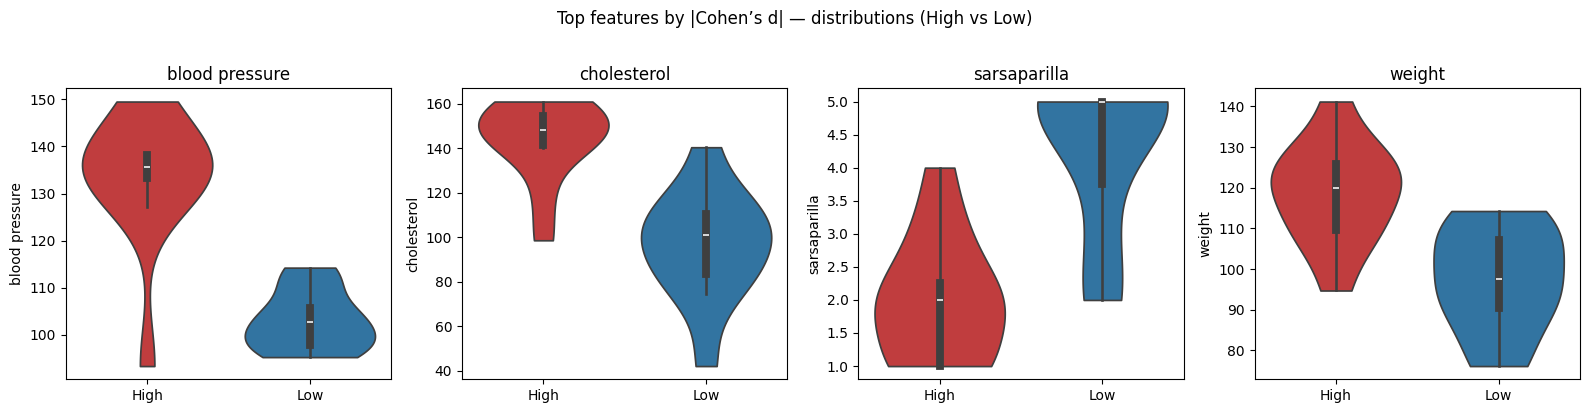

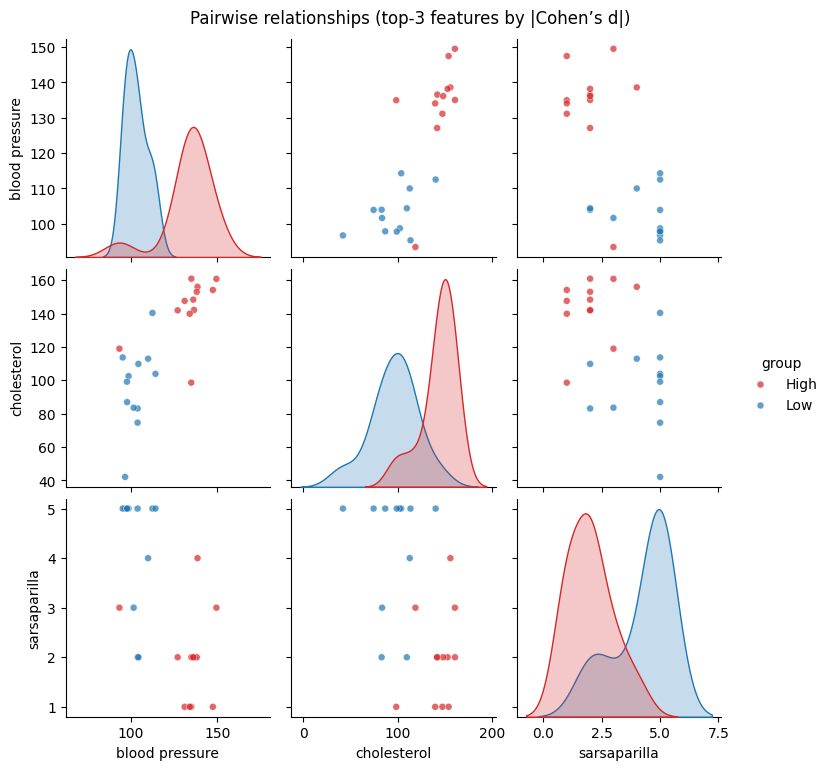

In [46]:
# Part 4 — Highest vs lowest risk analysis using the provided preprocessing setup

# Assumes the block you provided has already been run:
# - RANDOM_STATE, seeds
# - y_train, y_test loaded and raveled
# - X_train_clean/X_test_clean -> X_train/X_test after get_dummies + ordinal maps
# - img_train/img_test
# - X_tab_train/X_tab_test restricted to `cols`
# - dataset_viz defined
# - IMAGE_DIR_TEST available (if not, define it)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

IMAGE_DIR_TEST = "../data/data_labeled/Img_test"

# Build a test dataframe with filenames, the 8 tabular features, and true risk
df_test = X_test[['img_filename'] + cols].copy()
df_test['risk'] = y_test

# Select top-N highest risk and bottom-N lowest risk samples
N = 12
df_hi = df_test.sort_values('risk', ascending=False).head(N).reset_index(drop=True)
df_lo = df_test.sort_values('risk', ascending=True).head(N).reset_index(drop=True)

print("Top risk samples (highest):")
display(df_hi)
print("Low risk samples (lowest):")
display(df_lo)

# Helper to show image grids
def show_image_grid(filenames, img_dir, title, n_cols=6):
    imgs = []
    for fname in filenames:
        path = os.path.join(img_dir, fname)
        if os.path.exists(path):
            img = Image.open(path).convert("L")
            imgs.append(np.array(img))
        else:
            imgs.append(np.zeros((48, 48), dtype=np.uint8))
    n = len(imgs)
    n_rows = int(np.ceil(n / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.2*n_cols, 2.2*n_rows))
    axes = np.atleast_2d(axes)
    for i, ax in enumerate(axes.flatten()):
        ax.axis('off')
        if i < n:
            ax.imshow(imgs[i], cmap='gray', vmin=0, vmax=255)
    fig.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

# Show image grids
show_image_grid(df_hi['img_filename'].tolist(), IMAGE_DIR_TEST, f"Top {N} highest risk (test)")
show_image_grid(df_lo['img_filename'].tolist(), IMAGE_DIR_TEST, f"Top {N} lowest risk (test)")

# Differences in tabular features: mean differences
mean_hi = df_hi[cols].mean()
mean_lo = df_lo[cols].mean()
diff = mean_hi - mean_lo
diff_sorted = diff.reindex(diff.abs().sort_values(ascending=False).index)

plt.figure(figsize=(8, 4.5))
colors = ['tab:red' if v > 0 else 'tab:blue' for v in diff_sorted.values]
bars = plt.bar(diff_sorted.index, diff_sorted.values, color=colors, alpha=0.85, label='Mean difference (High − Low)')
for b, v in zip(bars, diff_sorted.values):
    plt.text(b.get_x() + b.get_width()/2, v, f"{v:.3f}",
             ha='center', va='bottom' if v>0 else 'top', fontsize=9)
legend_handles = [plt.Line2D([0], [0], color='tab:red', lw=8, label='Higher in High'),
                  plt.Line2D([0], [0], color='tab:blue', lw=8, label='Higher in Low')]
plt.legend(handles=legend_handles, loc='best')
plt.xticks(rotation=30, ha='right')
plt.ylabel("Mean difference (High − Low)")
plt.title("Feature mean differences: highest vs lowest risk (test)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Scale-aware comparison: Cohen's d
def cohen_d(a, b):
    a = np.asarray(a); b = np.asarray(b)
    mean_diff = a.mean() - b.mean()
    s_a = a.std(ddof=1); s_b = b.std(ddof=1)
    n_a, n_b = len(a), len(b)
    s_p = np.sqrt(((n_a-1)*s_a**2 + (n_b-1)*s_b**2) / (n_a + n_b - 2 + 1e-8))
    return mean_diff / (s_p + 1e-8)

effect_sizes = pd.Series({c: cohen_d(df_hi[c], df_lo[c]) for c in cols})
es_sorted = effect_sizes.reindex(effect_sizes.abs().sort_values(ascending=False).index)

plt.figure(figsize=(8, 4.5))
colors = ['tab:red' if v > 0 else 'tab:blue' for v in es_sorted.values]
bars = plt.bar(es_sorted.index, es_sorted.values, color=colors, alpha=0.85, label="Cohen's d")
for b, v in zip(bars, es_sorted.values):
    plt.text(b.get_x() + b.get_width()/2, v, f"{v:.2f}",
             ha='center', va='bottom' if v>0 else 'top', fontsize=9)
legend_handles = [plt.Line2D([0], [0], color='tab:red', lw=8, label="Higher mean in High"),
                  plt.Line2D([0], [0], color='tab:blue', lw=8, label="Higher mean in Low")]
plt.legend(handles=legend_handles, loc='best')
plt.xticks(rotation=30, ha='right')
plt.ylabel("Cohen's d (High vs Low)")
plt.title("Effect sizes per feature: highest vs lowest risk (test)")
plt.axhline(0, color='gray', lw=1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Distributions for the top-4 features by |Cohen's d|
top_features = es_sorted.index[:4].tolist()

df_long = pd.DataFrame()
for f in top_features:
    df_long = pd.concat([
        pd.DataFrame({'feature': f, 'value': df_hi[f].values, 'group': 'High'}),
        pd.DataFrame({'feature': f, 'value': df_lo[f].values, 'group': 'Low'}),
    ], axis=0)

g = sns.FacetGrid(df_long, col="feature", hue="group", sharex=False, sharey=False, col_wrap=2, height=3.2)
g.map(sns.kdeplot, "value", fill=True, alpha=0.4).add_legend()
g.fig.suptitle("Top features by effect size: High vs Low risk distributions (test)", y=1.02)
plt.show()


# 1) Grouped bar: mean ± std for High vs Low groups across features
means_hi = df_hi[cols].mean()
stds_hi  = df_hi[cols].std(ddof=1)
means_lo = df_lo[cols].mean()
stds_lo  = df_lo[cols].std(ddof=1)

x = np.arange(len(cols))
w = 0.38

plt.figure(figsize=(10, 5))
plt.bar(x - w/2, means_hi.values, yerr=stds_hi.values, capsize=4,
        color='tab:red', alpha=0.8, label='High (mean ± std)')
plt.bar(x + w/2, means_lo.values, yerr=stds_lo.values, capsize=4,
        color='tab:blue', alpha=0.8, label='Low (mean ± std)')
plt.xticks(x, cols, rotation=30, ha='right')
plt.ylabel('Value')
plt.title(f'Per-feature means ± std (Top {len(df_hi)} High vs Top {len(df_lo)} Low risk)')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Mean difference with error bars (standard error of difference)
#    SE(diff) = sqrt(std_hi^2 / n_hi + std_lo^2 / n_lo)
n_hi = len(df_hi)
n_lo = len(df_lo)
diff = means_hi - means_lo
se_diff = np.sqrt((stds_hi**2) / max(1, n_hi) + (stds_lo**2) / max(1, n_lo))

diff_sorted = diff.reindex(diff.abs().sort_values(ascending=False).index)
se_sorted = se_diff[diff_sorted.index]

plt.figure(figsize=(10, 5))
bars = plt.bar(diff_sorted.index, diff_sorted.values, yerr=se_sorted.values, capsize=4,
               color=['tab:red' if v > 0 else 'tab:blue' for v in diff_sorted.values], alpha=0.9)
for b, v in zip(bars, diff_sorted.values):
    plt.text(b.get_x() + b.get_width()/2, v, f"{v:.3f}",
             ha='center', va='bottom' if v>0 else 'top', fontsize=9)
plt.axhline(0, color='gray', lw=1)
plt.ylabel('Mean difference (High − Low) ± SE')
plt.title('Feature mean differences with standard error')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Violin + box for the top features by |Cohen’s d|
top_features = es_sorted.index[:4].tolist()
df_vio = pd.concat([
    df_hi[top_features].assign(group='High'),
    df_lo[top_features].assign(group='Low')
])

fig, axes = plt.subplots(1, len(top_features), figsize=(4*len(top_features), 4), sharey=False)
if len(top_features) == 1:
    axes = [axes]
for ax, f in zip(axes, top_features):
    sns.violinplot(data=df_vio, x='group', y=f, ax=ax, inner='box', cut=0,
                   palette={'High':'tab:red','Low':'tab:blue'})
    ax.set_xlabel('')
    ax.set_title(f)
fig.suptitle('Top features by |Cohen’s d| — distributions (High vs Low)', y=1.02)
plt.tight_layout()
plt.show()

# 6) Optional: pairwise scatter for top-3 features by |Cohen’s d|
top3 = es_sorted.index[:3].tolist()
df_pair = pd.concat([
    df_hi[top3].assign(group='High'),
    df_lo[top3].assign(group='Low')
])
sns.pairplot(df_pair, hue='group', diag_kind='kde',
             plot_kws={'alpha':0.7, 's':25},
             palette={'High':'tab:red','Low':'tab:blue'})
plt.suptitle('Pairwise relationships (top-3 features by |Cohen’s d|)', y=1.02)
plt.show()

## Compare the Top-12 highest risk group against the overall TEST distribution


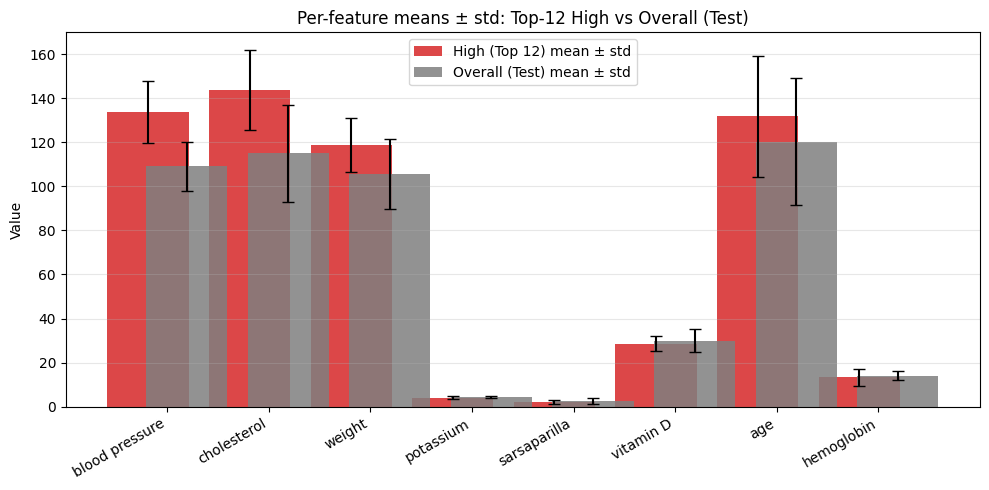

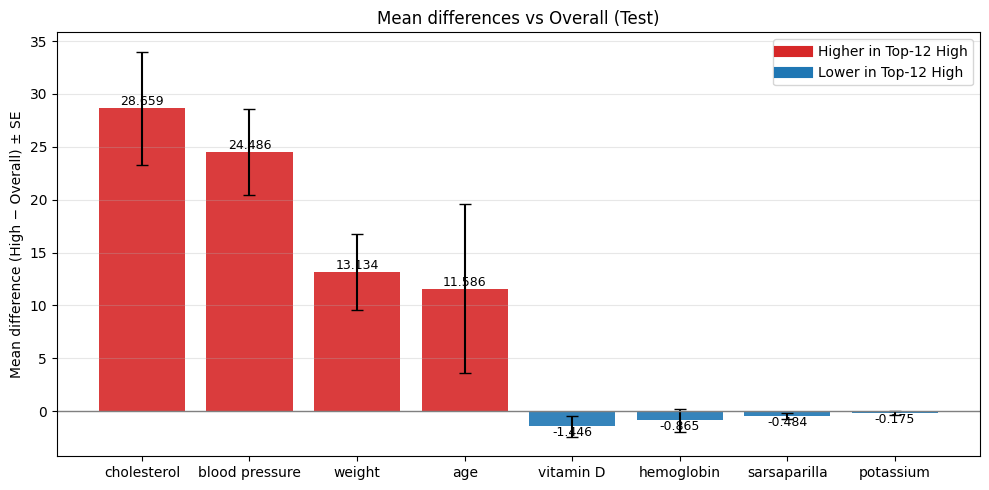

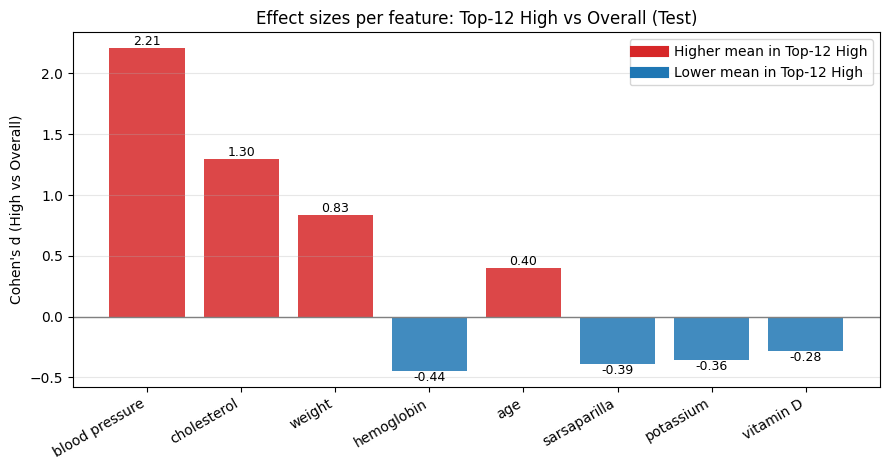

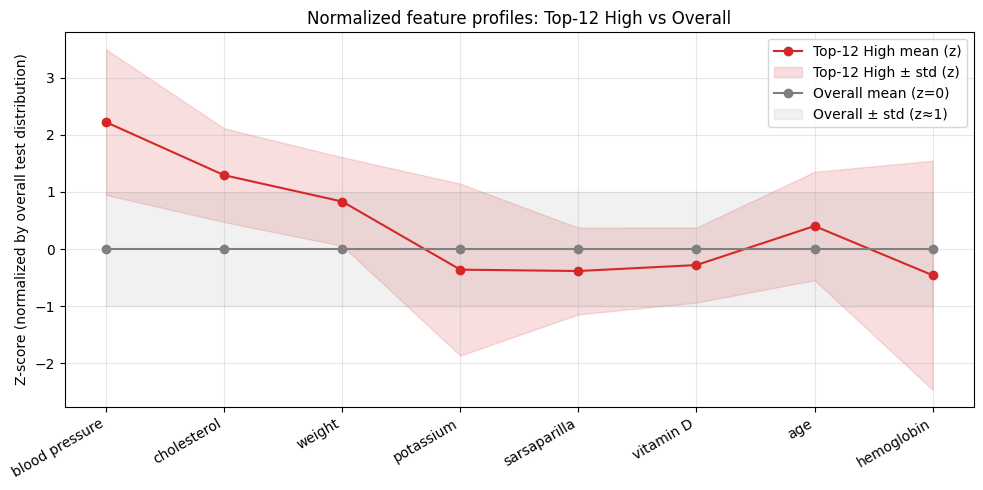

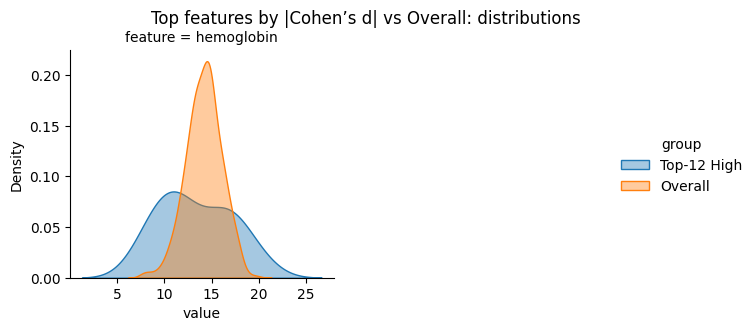

In [ ]:

# 0) Prepare overall stats (on the entire test set)
overall_means = df_test[cols].mean()
overall_stds  = df_test[cols].std(ddof=1)

# 1) Grouped bar: mean ± std (Top-12 High vs Overall)
means_hi = df_hi[cols].mean()
stds_hi  = df_hi[cols].std(ddof=1)

x = np.arange(len(cols))
w = 0.38

plt.figure(figsize=(10, 5))
plt.bar(x - w/2, means_hi.values, yerr=stds_hi.values, capsize=4,
        color='tab:red', alpha=0.85, label=f'High (Top {len(df_hi)}) mean ± std')
plt.bar(x + w/2, overall_means.values, yerr=overall_stds.values, capsize=4,
        color='tab:gray', alpha=0.85, label='Overall (Test) mean ± std')
plt.xticks(x, cols, rotation=30, ha='right')
plt.ylabel('Value')
plt.title('Per-feature means ± std: Top-12 High vs Overall (Test)')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Mean difference (High − Overall) with SE error bars
#    SE(diff) = sqrt(std_hi^2 / n_hi + std_overall^2 / n_overall)
n_hi = len(df_hi)
n_all = len(df_test)
mean_diff_ho = means_hi - overall_means
se_diff_ho = np.sqrt((stds_hi**2) / max(1, n_hi) + (overall_stds**2) / max(1, n_all))

md_sorted = mean_diff_ho.reindex(mean_diff_ho.abs().sort_values(ascending=False).index)
se_sorted = se_diff_ho[md_sorted.index]

plt.figure(figsize=(10, 5))
bars = plt.bar(md_sorted.index, md_sorted.values, yerr=se_sorted.values, capsize=4,
               color=['tab:red' if v > 0 else 'tab:blue' for v in md_sorted.values], alpha=0.9)
for b, v in zip(bars, md_sorted.values):
    plt.text(b.get_x() + b.get_width()/2, v, f"{v:.3f}",
             ha='center', va='bottom' if v>0 else 'top', fontsize=9)
legend_handles = [plt.Line2D([0], [0], color='tab:red', lw=8, label='Higher in Top-12 High'),
                  plt.Line2D([0], [0], color='tab:blue', lw=8, label='Lower in Top-12 High')]
plt.legend(handles=legend_handles, loc='best')
plt.axhline(0, color='gray', lw=1)
plt.ylabel('Mean difference (High − Overall) ± SE')
plt.title('Mean differences vs Overall (Test)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Effect size vs Overall: Cohen’s d (High vs Overall)
def cohen_d_groups(mean_a, mean_b, std_a, std_b, n_a, n_b):
    # pooled std
    s_p = np.sqrt(((n_a-1)*std_a**2 + (n_b-1)*std_b**2) / (n_a + n_b - 2 + 1e-8))
    return (mean_a - mean_b) / (s_p + 1e-8)

d_vs_overall = pd.Series({
    c: cohen_d_groups(means_hi[c], overall_means[c], stds_hi[c], overall_stds[c], n_hi, n_all)
    for c in cols
})
d_sorted = d_vs_overall.reindex(d_vs_overall.abs().sort_values(ascending=False).index)

plt.figure(figsize=(9, 4.8))
colors = ['tab:red' if v > 0 else 'tab:blue' for v in d_sorted.values]
bars = plt.bar(d_sorted.index, d_sorted.values, color=colors, alpha=0.85, label="Cohen's d (High vs Overall)")
for b, v in zip(bars, d_sorted.values):
    plt.text(b.get_x() + b.get_width()/2, v, f"{v:.2f}",
             ha='center', va='bottom' if v>0 else 'top', fontsize=9)
legend_handles = [plt.Line2D([0], [0], color='tab:red', lw=8, label='Higher mean in Top-12 High'),
                  plt.Line2D([0], [0], color='tab:blue', lw=8, label='Lower mean in Top-12 High')]
plt.legend(handles=legend_handles, loc='best')
plt.xticks(rotation=30, ha='right')
plt.ylabel("Cohen's d (High vs Overall)")
plt.title("Effect sizes per feature: Top-12 High vs Overall (Test)")
plt.axhline(0, color='gray', lw=1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 4) Normalized profiles (z-scores) relative to overall test distribution
overall_mean = overall_means
overall_std  = overall_stds.replace(0, 1e-8)  # guard against zero std

z_hi_mean = (means_hi - overall_mean) / overall_std
z_hi_std  = stds_hi / overall_std
z_all_mean = (overall_means - overall_mean) / overall_std  # = 0 by definition
z_all_std  = overall_stds / overall_std                     # = 1 by definition

idx = np.arange(len(cols))
plt.figure(figsize=(10, 5))
plt.plot(idx, z_hi_mean.values, '-o', color='tab:red', label='Top-12 High mean (z)')
plt.fill_between(idx, (z_hi_mean - z_hi_std).values, (z_hi_mean + z_hi_std).values,
                 color='tab:red', alpha=0.15, label='Top-12 High ± std (z)')
plt.plot(idx, z_all_mean.values, '-o', color='tab:gray', label='Overall mean (z=0)')
plt.fill_between(idx, (z_all_mean - z_all_std).values, (z_all_mean + z_all_std).values,
                 color='tab:gray', alpha=0.1, label='Overall ± std (z≈1)')
plt.xticks(idx, cols, rotation=30, ha='right')
plt.ylabel('Z-score (normalized by overall test distribution)')
plt.title('Normalized feature profiles: Top-12 High vs Overall')
plt.grid(alpha=0.3)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 5) KDE distributions for top-4 features by |Cohen’s d vs Overall|
top4_vs_all = d_sorted.index[:4].tolist()
df_long_vs_all = pd.DataFrame()
for f in top4_vs_all:
    df_long_vs_all = pd.concat([
        pd.DataFrame({'feature': f, 'value': df_hi[f].values,         'group': 'Top-12 High'}),
        pd.DataFrame({'feature': f, 'value': df_test[f].values,       'group': 'Overall'}),
    ], axis=0)

g = sns.FacetGrid(df_long_vs_all, col="feature", hue="group", sharex=False, sharey=False, col_wrap=2, height=3.2)
g.map(sns.kdeplot, "value", fill=True, alpha=0.4).add_legend()
g.fig.suptitle("Top features by |Cohen’s d| vs Overall: distributions", y=1.02)
plt.show()

in the Cohen's graph the Top‑12 high‑risk group’s mean blood pressure is about 2.21 pooled standard deviations higher than the overall test set’s mean.

mean(Top‑12 High) − mean(Overall) ≈ 2.21 × pooled_std